In [17]:
import re
import string
import pandas as pd
from math import fabs
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression,LinearRegression,PassiveAggressiveRegressor
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from nltk.stem.porter import PorterStemmer
from scipy.sparse import hstack
from sklearn.svm import SVR
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,mean_squared_log_error
from sklearn.model_selection import KFold

## Download NLTK libraries if you don't have those.

In [2]:
#nltk.download()

### Reading CSV in Pandas dataframe

In [3]:
raw_data = pd.read_csv('./Data/data.csv')

# Preprocessing total data

### Splitting Question titles

In [4]:
stop = set(stopwords.words('english'))
#remove punctuations from a string and convert to lower case
raw_data['questions_title'] = raw_data['questions_title'].apply(lambda x:''.join([i.lower() for i in x 
                                                  if i not in string.punctuation]))

#remove stop words
raw_data['questions_title'] = raw_data['questions_title'].apply(lambda x:' '.join([i for i in x.split(' ') 
                                                  if i not in stop]))

#removing digits
raw_data['questions_title'] = raw_data['questions_title'].apply(lambda x:' '.join([i.replace(r'[0-9]+','') for i in x.split(' ') ]))

### Splitting Question Tags

In [5]:
#remove pipe and seperate tags
raw_data['questions_tags'] = raw_data['questions_tags'].apply(lambda x:' '.join([i.lower() for i in x.split('|')]))

## Vectorizing the data and performing stemming

In [6]:
stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    # remove non letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # tokenize
    tokens = text.split()
    # stem
    stems = stem_tokens(tokens, stemmer)
    return stems

vectorizer = CountVectorizer(
    analyzer='word',
    tokenizer=tokenize,
    lowercase=True,
    stop_words='english'
)
train_x_que_tag = vectorizer.fit_transform(raw_data.questions_tags)
train_x_que_title = vectorizer.fit_transform(raw_data.questions_title)
train_y = raw_data['time'].tolist()

In [7]:
print train_x_que_tag.shape
print train_x_que_title.shape

(99999, 10660)
(99999, 32219)


### Combining Questions Tags and Question Titles feature vectors

In [8]:
train_x =  hstack((train_x_que_tag, train_x_que_title))

In [9]:
print train_x.shape

(99999, 42879)


## Evaluation Metrics

### Accuracy Score

In [10]:
def calc_accuracy(actual,predicted):
    tc = 0
    for ind in range(len(actual)):
        if abs(fabs(actual[ind])-fabs(predicted[ind])) <= 36000:
            tc = tc + 1
    return float(tc)*100/len(actual)

### Mean Squared Log Error

In [11]:
def calc_mean_squared_log_error(actual,predicted):
    return mean_squared_log_error(actual,predicted)

### Writing results to file

In [12]:
def writetofile(Y_test,result,i):
    f = open("result" + str(i+1),"w")
    for j in range(0,len(Y_test)):
        f.write(str(Y_test[j]) + "," + str(result[j]) + "\n")
    f.close()

## PassiveAggressive Regression

In [13]:
def PA_regressor(X_train,Y_train,X_test):
    passive_aggressive_regressor = PassiveAggressiveRegressor()
    passive_aggressive_regressor.fit(X_train,Y_train)
    prediction_result = passive_aggressive_regressor.predict(X_test)
    return prediction_result

In [14]:
accuracies = []
msle = []
for i in range(0,10):
    X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=10000)
    result = PA_regressor(X_train,Y_train,X_test)
    accuracies.append(calc_accuracy(Y_test,result))
    msle.append(calc_mean_squared_log_error(Y_test,np.abs(result)))
    #writetofile(Y_test,result,i)
print "Accuracy is ",
print accuracies
print "Mean Squared Log Error is : ",
print msle

C:\Users\admin\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.passive_aggressive.PassiveAggressiveRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuracy is  [79.71, 79.63, 80.12, 80.09, 80.22, 79.94, 79.77, 80.22, 79.82, 79.5]
Mean Squared Log Error is :  [7.8692382558596528, 7.9177926987985989, 8.0892367929850728, 7.9045356874794637, 7.8056672803009439, 7.7576525192706436, 8.006507342557736, 7.7067060212125549, 7.938423274455003, 8.0672984299104726]


In [15]:
print "Average Accuracy : ",
print sum(accuracies)/len(accuracies)
print "Average Mean Squared Error : ",
print sum(msle)/len(msle)

Average Accuracy :  79.902
Average Mean Squared Error :  7.90630583028


### Plot 10 fold validation of accuracy and Mean Squared Log Error

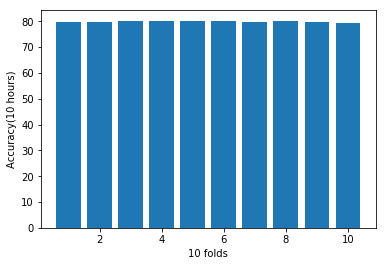

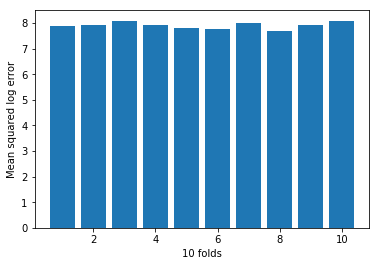

In [18]:
x = [1,2,3,4,5,6,7,8,9,10]

plt.bar(x,accuracies,align='center')
plt.ylabel('Accuracy(10 hours)')
plt.xlabel('10 folds')
plt.show()

plt.bar(x, msle, align = 'center')
plt.ylabel('Mean squared log error')
plt.xlabel('10 folds')
plt.show()